In [478]:
#SPOTIFY FEATURES
import requests
import pandas as pd
import time
import os


# Scraping top songs from spotifycharts.com for the week of 2019-01-25

In [ ]:
# All country codes list used on spotifycharts.com

country_codes_all = ['ad', 'ar', 'at', 'au', 'be', 'bg', 'bo', 'br', 'ca', 'ch', 'cl', 'co', 'cr',
                 'cy', 'cz', 'de', 'dk', 'do', 'ec', 'ee', 'es', 'fi', 'fr', 'gb', 'gr', 'gt',
                 'hk', 'hn', 'hu', 'id', 'ie', 'il', 'is', 'it', 'jp', 'lt', 'lu', 'lv', 'mc',
                 'mt', 'mx','my', 'ni', 'nl', 'no', 'nz', 'pa', 'pe', 'ph', 'pl', 'pt', 'py',
                 'ro', 'se', 'sg', 'sk', 'sv', 'th', 'tr', 'tw', 'us', 'uy', 'vn']

# Clean List of country codes - Removed ad & mc because they had no data for last week - see counter below
country_codes = ['ar', 'at', 'au', 'be', 'bg', 'bo', 'br', 'ca', 'ch', 'cl', 'co', 'cr',
                 'cy', 'cz', 'de', 'dk', 'do', 'ec', 'ee', 'es', 'fi', 'fr', 'gb', 'gr', 'gt',
                 'hk', 'hn', 'hu', 'id', 'ie', 'il', 'is', 'it', 'jp', 'lt', 'lu', 'lv',
                 'mt', 'mx','my', 'ni', 'nl', 'no', 'nz', 'pa', 'pe', 'ph', 'pl', 'pt', 'py',
                 'ro', 'se', 'sg', 'sk', 'sv', 'th', 'tr', 'tw', 'us', 'uy', 'vn']

In [ ]:
# Webscraping 

from bs4 import BeautifulSoup

#Loop to scrape top 10 songs (out of 200) by country and add Ids to a list for each country
top10_bycountry = {}
for country in country_codes:
    charts = f'https://spotifycharts.com/regional/{country}/weekly/2019-01-25--2019-02-01'
    html_page = requests.get(charts) #Make a get request to retrieve the page
    soup = BeautifulSoup(html_page.content, 'html.parser') #Pass the page contents to beautiful soup for parsing
    
    top_links = []
    top10_links = []
    for link in soup.findAll('a',target="_blank"):
        top_links.append((link.get('href')))
        top10_links = top_links[1:11]        #Retaining 10 songs out of top 200

    top10_ids = []
    for x in top10_links:
        x = x[-22:]                  #Last 22 digits contain the track ID
        top10_ids.append(x)
    top10_bycountry[country] = top10_ids

In [ ]:
# Counting which country returns empty ID for the week

counter = 0
for k,v in top10_bycountry.items():
    if len(v) == 0:
        print(k)
        counter +=1
counter

In [ ]:
# Keeping a subset of unique track IDs for the API Call
all_songs = []
for n in list(top10_bycountry.values()):
    for x in n:
        all_songs.append(x)
unique = list(set(all_songs))           # Unique list of track IDs

# API call to Spotify

In [479]:
#Credentials - Oauth to access track features
client_id =  '5ce71a6138664aff9b24f6da2da63333'
secret = '166aca7c7cce4b168cd95f6f7429bc98'

Oauth ='BQBVC84OMxnxTc2XjrmzBSljKnBNTrNw3Z0G-6qKDRwctdTGxX1gpbouxwCOL7FO5oBkzL0nB8GcgSjKAKK3wLD9lrRdFbcOeDbKsm4o8jOvcMFAfqz9zqsPPd2aGKR66xO6d_juea4e'


In [437]:
#Splitting unique songs into two lists because limit per request is 100

first = unique[:100]
second = unique[100:]

#Creating comma separated string of tracks to pass into API calls for the tracks_ids parameter
i = ''
for x in first:
    if x == first[-1]:
        i = i+x
    else:
        i = i+x+','
j = ''
for x in second:
    if x == second[-1]:
        j = j+x
    else:
        j = j+x+','
both = [i,j]

In [457]:
# API call to Spotify to get track features of songs
# Maximum of 100 tracks per API call, loop into "both" list because we have a total of 184 unique tracks

def spotify_call(both):
    result = []
    for x in both:
        track_ids = x
        url= 'https://api.spotify.com/v1/audio-features'
        headers = {"Authorization": "Bearer {}".format(Oauth),}
        url_params = {'ids' : track_ids.replace(' ', '+'),}
        response = requests.get(url,headers=headers,params= url_params)
        result.append(response.json()) 
    return result

In [458]:
# Results of API call
a = spotify_call(both)

In [475]:
# Concatenating the two lists resulting from API call into 1 dataframe.

df1 = pd.DataFrame(a[0]['audio_features'])
df2 = pd.DataFrame(a[1]['audio_features'])
df = pd.concat([df1,df2])

In [585]:
# Checking for incomplete data, column names and making sure total matches number of unique tracks
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 0 to 83
Data columns (total 18 columns):
acousticness        184 non-null float64
analysis_url        184 non-null object
danceability        184 non-null float64
duration_ms         184 non-null int64
energy              184 non-null float64
id                  184 non-null object
instrumentalness    184 non-null float64
key                 184 non-null int64
liveness            184 non-null float64
loudness            184 non-null float64
mode                184 non-null int64
speechiness         184 non-null float64
tempo               184 non-null float64
time_signature      184 non-null int64
track_href          184 non-null object
type                184 non-null object
uri                 184 non-null object
valence             184 non-null float64
dtypes: float64(9), int64(4), object(5)
memory usage: 27.3+ KB


In [586]:
# Transpose column countries into row names. Columns become the ranking of top10.
top10_byct_df = (pd.DataFrame(top10_bycountry)).T
top10_byct_df.head()

,0,1,2,3,4,5,6,7,8,9
ar,5iwz1NiezX7WWjnCgY5TH4,6FyRXC8tJUh863JCkyWqtk,0s5DNDV6LAKn2u2Ufa3VjQ,6MJUCumnQsQEKbCy28tbCP,3dLiBBKbeUIhzGNeuo5JGS,116H0KvKr2Zl4RPuVBruDO,5W83ErFkO3aKAIS1WMi6u0,2D3z17LBMJ2HEHeBFFjTLi,22sESxzbY1O1E19xjOTaYf,4w8niZpiMy6qz1mntFA5uM
at,7r55d7IhAj5UGKiYbXBwRP,260R90ctQ1SiPax90PuEsT,14msK75pk3pA33pzPVNtBF,7KPGeiXWDsGEvFK62wzU8E,25sgk305KZfyuqVBQIahim,63THFs9ovzO3WQsz4lzh0H,1rqqCSm0Qe4I9rUvWncaom,1IPRghUN3LFPNbCTsfBJx9,2PAYSgrVOBz8RJqp9B7QLu,5z3vuYzS9UF6rD6TmBEdUf
au,14msK75pk3pA33pzPVNtBF,3KkXRkHbMCARz0aVfEt68P,6MWtB6iiXyIwun0YzU6DFP,5p7ujcrUXASCNwRaWNHR1C,6Qs4SXO9dwPj5GKvVOv8Ki,25sgk305KZfyuqVBQIahim,2rPE9A1vEgShuZxxzR2tZH,2xLMifQCjDGFmkHkpNLD9h,7FGq80cy8juXBCD2nrqdWU,7to68V64Cu6zk0UDo5tyw3
be,14msK75pk3pA33pzPVNtBF,25sgk305KZfyuqVBQIahim,1rqqCSm0Qe4I9rUvWncaom,5p7ujcrUXASCNwRaWNHR1C,2VxeLyX666F8uXCJ0dZF8B,6MWtB6iiXyIwun0YzU6DFP,3EPXxR3ImUwfayaurPi3cm,2rPE9A1vEgShuZxxzR2tZH,5itOtNx0WxtJmi1TQ3RuRd,6Qs4SXO9dwPj5GKvVOv8Ki
bg,14msK75pk3pA33pzPVNtBF,5p7ujcrUXASCNwRaWNHR1C,6MWtB6iiXyIwun0YzU6DFP,2JvzF1RMd7lE3KmFlsyZD8,7wFybC8jBH3zE139OpCtpG,2xLMifQCjDGFmkHkpNLD9h,2VxeLyX666F8uXCJ0dZF8B,2IRZnDFmlqMuOrYOLnZZyc,6Qs4SXO9dwPj5GKvVOv8Ki,54ikdt0wnIMn8sT9NFgFSS


In [544]:
# Stacking in order to be able to merge with the track Id features obtained from Spotify
stacked_df = top10_byct_df.stack()
df3 = pd.DataFrame(stacked_df.rename('id')).head()

id
ar 0  5iwz1NiezX7WWjnCgY5TH4
   1  6FyRXC8tJUh863JCkyWqtk
   2  0s5DNDV6LAKn2u2Ufa3VjQ
   3  6MJUCumnQsQEKbCy28tbCP
   4  3dLiBBKbeUIhzGNeuo5JGS
   5  116H0KvKr2Zl4RPuVBruDO
   6  5W83ErFkO3aKAIS1WMi6u0
   7  2D3z17LBMJ2HEHeBFFjTLi
   8  22sESxzbY1O1E19xjOTaYf
   9  4w8niZpiMy6qz1mntFA5uM
at 0  7r55d7IhAj5UGKiYbXBwRP
   1  260R90ctQ1SiPax90PuEsT
   2  14msK75pk3pA33pzPVNtBF
   3  7KPGeiXWDsGEvFK62wzU8E
   4  25sgk305KZfyuqVBQIahim
   5  63THFs9ovzO3WQsz4lzh0H
   6  1rqqCSm0Qe4I9rUvWncaom
   7  1IPRghUN3LFPNbCTsfBJx9
   8  2PAYSgrVOBz8RJqp9B7QLu
   9  5z3vuYzS9UF6rD6TmBEdUf

In [552]:
#To put back country codes & rankings as column names
df3.reset_index(inplace=True)

In [602]:
# Renaming column names
df3.rename(columns={'country':'code','level_1':'rank'},inplace=True)
df3.head()

,code,rank,id
0,ar,0,5iwz1NiezX7WWjnCgY5TH4
1,ar,1,6FyRXC8tJUh863JCkyWqtk
2,ar,2,0s5DNDV6LAKn2u2Ufa3VjQ
3,ar,3,6MJUCumnQsQEKbCy28tbCP
4,ar,4,3dLiBBKbeUIhzGNeuo5JGS


In [604]:
# Merging table df3 containing country top 10 songs to table df containing music features
merged_top10_features = df3.merge(df,how='left')

In [605]:
merged_top10_features.head()

,code,rank,id,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,ar,0,5iwz1NiezX7WWjnCgY5TH4,0.323,https://api.spotify.com/v1/audio-analysis/5iwz...,0.826,238200,0.773,0.000000,11,0.1430,-4.218,0,0.0524,126.899,4,https://api.spotify.com/v1/tracks/5iwz1NiezX7W...,audio_features,spotify:track:5iwz1NiezX7WWjnCgY5TH4,0.761
1,ar,1,6FyRXC8tJUh863JCkyWqtk,0.323,https://api.spotify.com/v1/audio-analysis/6FyR...,0.767,258639,0.709,0.000000,1,0.0676,-4.470,1,0.3360,171.993,4,https://api.spotify.com/v1/tracks/6FyRXC8tJUh8...,audio_features,spotify:track:6FyRXC8tJUh863JCkyWqtk,0.720
2,ar,2,0s5DNDV6LAKn2u2Ufa3VjQ,0.146,https://api.spotify.com/v1/audio-analysis/0s5D...,0.709,204453,0.771,0.000003,7,0.2490,-4.598,1,0.1660,174.006,4,https://api.spotify.com/v1/tracks/0s5DNDV6LAKn...,audio_features,spotify:track:0s5DNDV6LAKn2u2Ufa3VjQ,0.709
3,ar,3,6MJUCumnQsQEKbCy28tbCP,0.291,https://api.spotify.com/v1/audio-analysis/6MJU...,0.788,207853,0.771,0.000056,4,0.1720,-3.206,0,0.0563,99.038,4,https://api.spotify.com/v1/tracks/6MJUCumnQsQE...,audio_features,spotify:track:6MJUCumnQsQEKbCy28tbCP,0.701
4,ar,4,3dLiBBKbeUIhzGNeuo5JGS,0.420,https://api.spotify.com/v1/audio-analysis/3dLi...,0.641,244771,0.652,0.000002,8,0.0940,-8.575,0,0.2640,175.022,4,https://api.spotify.com/v1/tracks/3dLiBBKbeUIh...,audio_features,spotify:track:3dLiBBKbeUIhzGNeuo5JGS,0.406


In [608]:
# To make the column "code" more readable, mapping to country name
country_names = pd.read_csv('country_codes.csv')
country_names.head()

,code,country
0,ad,Andorra
1,ae,United Arab Emirates
2,af,Afghanistan
3,ag,Antigua and Barbuda
4,ai,Anguilla


In [620]:
# Merging country names into table and dropping "code" column
merged_top10_feat = merged_top10_features.merge(country_names,how='left')
merged_top10_feat.set_index('country',inplace=True)
merged_top10_feat.drop('code',axis = 1, inplace=True)
merged_top10_feat.head()

,rank,id,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
country,,,,,,,,,,,,,,,,,,,
Argentina,0,5iwz1NiezX7WWjnCgY5TH4,0.323,https://api.spotify.com/v1/audio-analysis/5iwz...,0.826,238200,0.773,0.000000,11,0.1430,-4.218,0,0.0524,126.899,4,https://api.spotify.com/v1/tracks/5iwz1NiezX7W...,audio_features,spotify:track:5iwz1NiezX7WWjnCgY5TH4,0.761
Argentina,1,6FyRXC8tJUh863JCkyWqtk,0.323,https://api.spotify.com/v1/audio-analysis/6FyR...,0.767,258639,0.709,0.000000,1,0.0676,-4.470,1,0.3360,171.993,4,https://api.spotify.com/v1/tracks/6FyRXC8tJUh8...,audio_features,spotify:track:6FyRXC8tJUh863JCkyWqtk,0.720
Argentina,2,0s5DNDV6LAKn2u2Ufa3VjQ,0.146,https://api.spotify.com/v1/audio-analysis/0s5D...,0.709,204453,0.771,0.000003,7,0.2490,-4.598,1,0.1660,174.006,4,https://api.spotify.com/v1/tracks/0s5DNDV6LAKn...,audio_features,spotify:track:0s5DNDV6LAKn2u2Ufa3VjQ,0.709
Argentina,3,6MJUCumnQsQEKbCy28tbCP,0.291,https://api.spotify.com/v1/audio-analysis/6MJU...,0.788,207853,0.771,0.000056,4,0.1720,-3.206,0,0.0563,99.038,4,https://api.spotify.com/v1/tracks/6MJUCumnQsQE...,audio_features,spotify:track:6MJUCumnQsQEKbCy28tbCP,0.701
Argentina,4,3dLiBBKbeUIhzGNeuo5JGS,0.420,https://api.spotify.com/v1/audio-analysis/3dLi...,0.641,244771,0.652,0.000002,8,0.0940,-8.575,0,0.2640,175.022,4,https://api.spotify.com/v1/tracks/3dLiBBKbeUIh...,audio_features,spotify:track:3dLiBBKbeUIhzGNeuo5JGS,0.406


In [621]:
average_features = merged_top10_feat.groupby('country').mean()

In [626]:
(average_features.sort_values('energy',ascending = False)).head()

,rank,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
country,,,,,,,,,,,,,,
Brazil,4.5,0.399910,0.7148,166936.4,0.8130,4.540000e-07,6.4,0.44059,-3.3003,0.6,0.09571,136.9498,4.0,0.6579
Bolivia (Plurinational State of),4.5,0.214670,0.7896,221053.8,0.7471,9.213220e-04,6.3,0.11062,-4.1762,0.7,0.13470,114.3072,4.0,0.6644
Panama,4.5,0.265220,0.7691,218169.1,0.7450,9.166490e-04,7.9,0.13179,-4.0124,0.4,0.13228,133.0277,4.0,0.6013
Ecuador,4.5,0.228470,0.7843,220589.1,0.7444,9.266090e-04,6.6,0.12164,-4.0762,0.7,0.11743,114.6162,4.0,0.6754
Japan,4.5,0.148175,0.6219,249978.7,0.7428,1.140000e-06,3.9,0.11005,-4.8187,0.9,0.06754,106.1545,4.0,0.5212


In [628]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [ ]:
currentpalette = sns.color_palette(palette = "muted",n_colors = 20)
sns.set_palette(currentpalette)


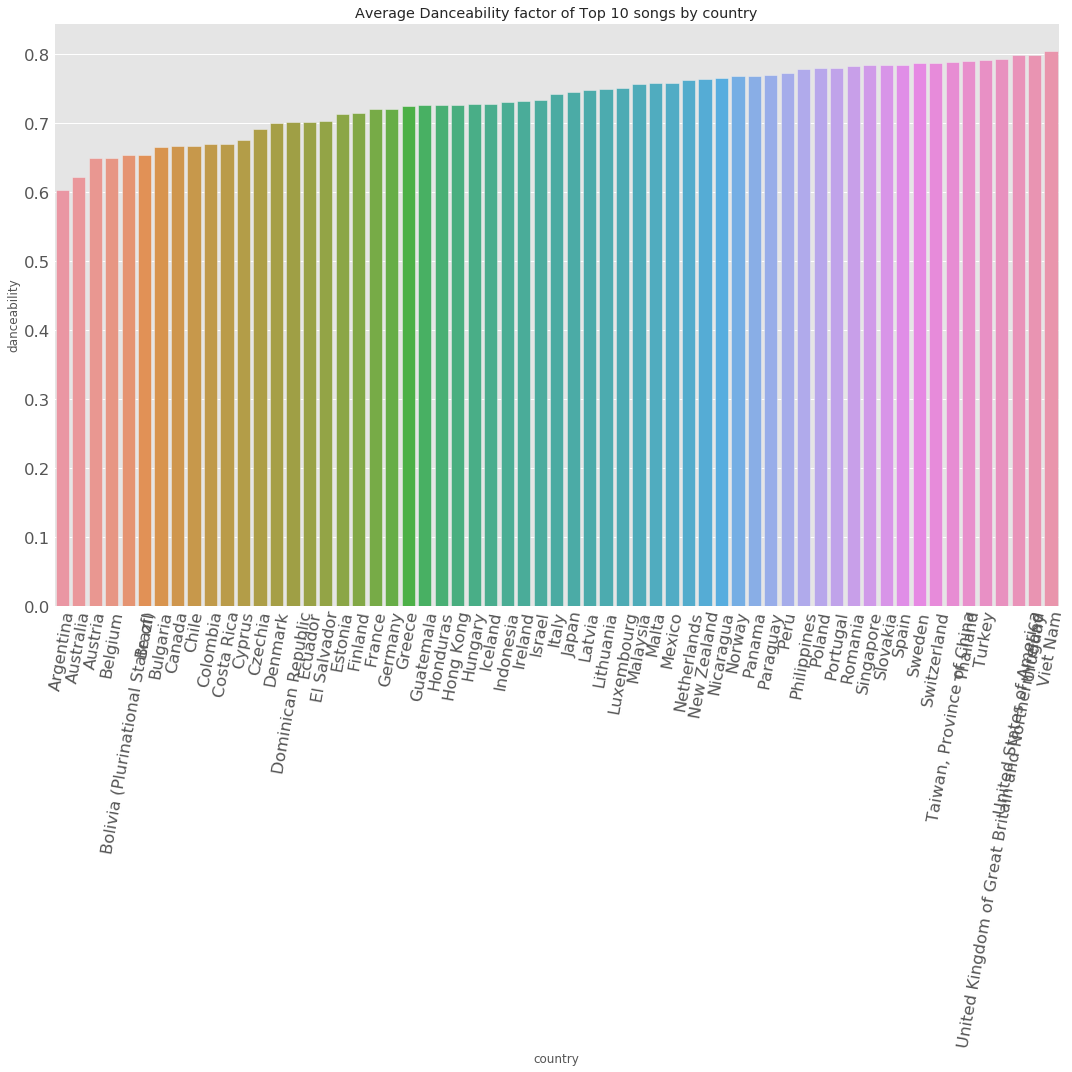

In [741]:
plt.style.use("ggplot")
plt.figure(figsize=(15,15))
dance_plot = sns.barplot(x=average_features.index,
                         y=(average_features.sort_values('danceability',ascending = True)).danceability,
                        )
plt.xticks(rotation=80)
plt.title('Average Danceability factor of Top 10 songs by country')
plt.tight_layout()



Text(0.5, 1.0, 'Scatter Plot - Tempo and Danceability')

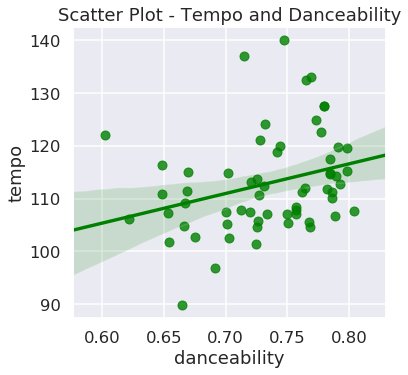

In [788]:
# plt.style.use("fivethirtyeight")
# sns.set(style="darkgrid", context="talk")
plt.figure(figsize=(5,5))
dance_energy = sns.regplot(x=average_features.danceability,
                         y=average_features.tempo,
                        color = 'green')
plt.title('Scatter Plot - Tempo and Danceability')

/Users/pacman/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


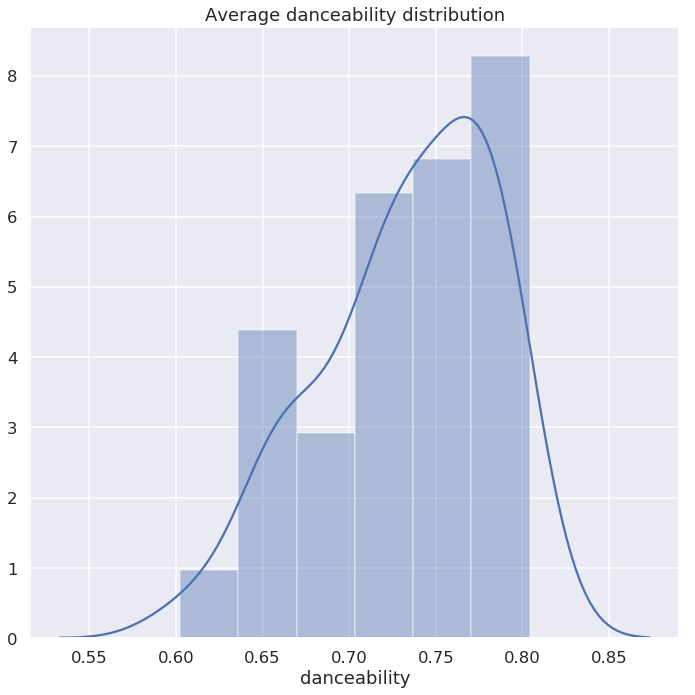

In [757]:
plt.style.use("ggplot")
sns.set(style="darkgrid", context="talk")
plt.figure(figsize=(10,10))
dance_plot = sns.distplot(average_features.danceability)
plt.title('Average danceability distribution')
plt.tight_layout()

In [750]:
correl = average_features.drop(['rank','key','time_signature','mode'],axis = 1)
correl.head()


,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
country,,,,,,,,,,
Argentina,0.250260,0.7474,217217.1,0.7308,0.000919,0.12684,-4.7433,0.16828,140.0457,0.6188
Australia,0.301093,0.7310,199032.7,0.5676,0.000001,0.12723,-6.9632,0.13126,112.4793,0.4896
Austria,0.307620,0.7202,181236.6,0.6754,0.000005,0.12119,-6.1327,0.19563,113.0906,0.5042
Belgium,0.311410,0.7005,192785.7,0.5981,0.000052,0.12304,-6.2793,0.09154,107.5602,0.4700
Bolivia (Plurinational State of),0.214670,0.7896,221053.8,0.7471,0.000921,0.11062,-4.1762,0.13470,114.3072,0.6644


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text xticklabel objects>)

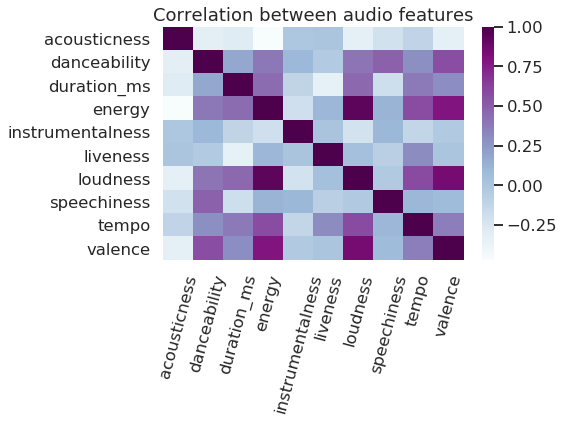

In [775]:
sns.heatmap(correl.corr(),cmap="BuPu")
plt.title('Correlation between audio features')
plt.xticks(rotation=75)

In [781]:
import numpy as np
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.util.hex import hexbin

x = average_features.energy
y = average_features.loudness
bins = hexbin(x, y, 0.01)
p = figure(tools="wheel_zoom,reset", match_aspect=True, background_fill_color='#440154')
p.grid.visible = False
p.hex_tile(q="q", r="r", size=0.1, line_color=None, source=bins,
           fill_color=linear_cmap('counts', 'Viridis256', 0, max(bins.counts)))
output_file("hex_tile.html")
show(p)